In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = "{}{}-{}".format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = "cu80" if path.exists("/opt/bin/nvidia-smi") else "cpu"

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [58]:
!pip install Pillow==4.0.0
!pip install image

  Using cached Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 5.0.0
    Uninstalling Pillow-5.0.0:
      Successfully uninstalled Pillow-5.0.0


In [0]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.autograd import Variable
from torchvision import transforms

from sklearn import metrics

In [0]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(style="whitegrid", palette="muted", font_scale=1.5)

rcParams["figure.figsize"] = 12, 8

In [0]:
!mkdir -p data

In [64]:
!wget http://files.fast.ai/data/cifar10.tgz

--2018-03-08 20:27:27--  http://files.fast.ai/data/cifar10.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168168549 (160M) [text/plain]
Saving to: ‘cifar10.tgz.1’

cifar10.tgz.1       100%[===================>] 160.38M  20.6MB/s    in 9.9s    

2018-03-08 20:27:37 (16.3 MB/s) - ‘cifar10.tgz.1’ saved [168168549/168168549]



In [0]:
!tar -xzf cifar10.tgz -C data/

In [0]:
PATH = "data/cifar10/"

In [67]:
!ls {PATH}/

labels.txt  test  train


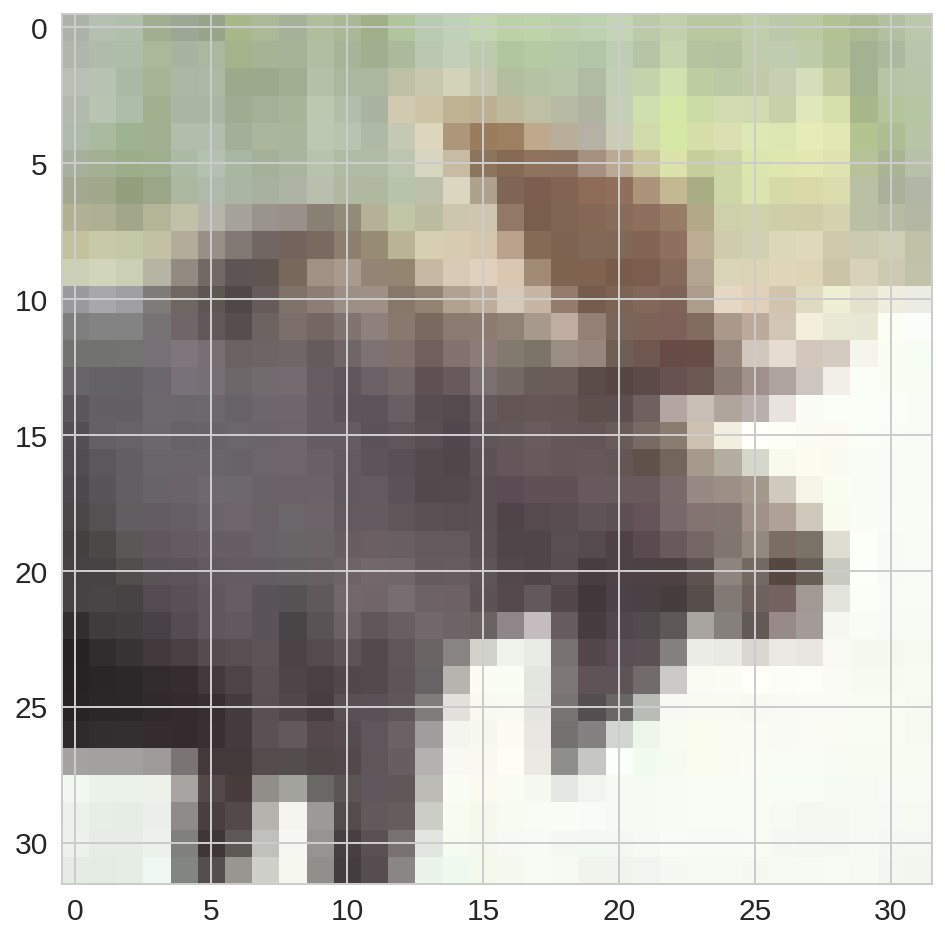

In [68]:
img = plt.imread(f"{PATH}test/deer/8126_deer.png")
plt.imshow(img);

In [69]:
img.shape

(32, 32, 3)

In [0]:
import torch.utils.data as data
import torchvision.datasets as datasets
import os

traindir = PATH + "train"
testdir = PATH + "test"

train_loader = data.DataLoader(
    datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.ToTensor()
        ])
    ),
    batch_size=64,
    shuffle=True,
    pin_memory=True
)

test_loader = data.DataLoader(
    datasets.ImageFolder(
        testdir,
        transforms.Compose([
            transforms.ToTensor()
        ])
    ),
    batch_size=64,
    shuffle=False,
    pin_memory=False
)

In [71]:
len(train_loader.dataset.imgs)

50000

In [72]:
len(test_loader.dataset.imgs)

10000

In [0]:
batch = next(iter(train_loader))

In [0]:
X, y = batch

In [75]:
X[0].shape

torch.Size([3, 32, 32])

In [0]:
def show_image(tensor_data):
    im = tensor_data.numpy()
    im = np.transpose(im, (1,2,0))
    plt.imshow(im)
    plt.show()

In [77]:
y[0]

7

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        
        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgPool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.normal = nn.BatchNorm2d(64)
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(64*4*4, 10)

    def forward(self, x): 
        x = self.maxPool(F.relu(self.conv1(x)))
        x = self.avgPool(F.relu(self.conv2(x)))
        x = self.avgPool(F.relu(self.conv3(x)))
        
        x = self.normal(x)
        
        x = x.view(-1, 64*4*4)
        x = self.drop(x)
        x = self.fc(x)
        return x

In [0]:
model = CNN()

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    criterion = criterion.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [80]:
train_loss = []
test_loss = []

EPOCHS_TO_TRAIN = 50

for epoch in range(EPOCHS_TO_TRAIN):
    model.train()
    e_train_loss = []
    for data, target in train_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()

        y_pred = model(data)

        loss = criterion(y_pred, target)
        e_train_loss.append(loss.data[0])
        
        loss.backward()
        optimizer.step()
        
    mean_train_loss = np.mean(e_train_loss)
    train_loss.append(mean_train_loss)
        
    model.eval()
    e_test_loss = []
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target, volatile=True)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss = criterion(output, target).data[0]
        e_test_loss.append(loss)
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    mean_test_loss = np.mean(e_test_loss)
    test_loss.append(mean_test_loss)
    
    print(
        f"{epoch + 1}. Test accuracy: {correct}/{len(test_loader.dataset)} {100. * correct / len(test_loader.dataset)}%",
    )

1. Test accuracy: 5161/10000 51.61%
2. Test accuracy: 6312/10000 63.12%
3. Test accuracy: 6682/10000 66.82%
4. Test accuracy: 6996/10000 69.96%
5. Test accuracy: 6920/10000 69.2%
6. Test accuracy: 7041/10000 70.41%
7. Test accuracy: 7243/10000 72.43%
8. Test accuracy: 6292/10000 62.92%
9. Test accuracy: 7149/10000 71.49%
10. Test accuracy: 7384/10000 73.84%
11. Test accuracy: 7503/10000 75.03%
12. Test accuracy: 7336/10000 73.36%
13. Test accuracy: 7407/10000 74.07%
14. Test accuracy: 7476/10000 74.76%
15. Test accuracy: 7624/10000 76.24%
16. Test accuracy: 7557/10000 75.57%
17. Test accuracy: 7529/10000 75.29%
18. Test accuracy: 7519/10000 75.19%
19. Test accuracy: 7626/10000 76.26%
20. Test accuracy: 7494/10000 74.94%
21. Test accuracy: 7681/10000 76.81%
22. Test accuracy: 7700/10000 77.0%
23. Test accuracy: 7603/10000 76.03%
24. Test accuracy: 7506/10000 75.06%
25. Test accuracy: 7603/10000 76.03%
26. Test accuracy: 7515/10000 75.15%
27. Test accuracy: 7508/10000 75.08%
28. Test acc

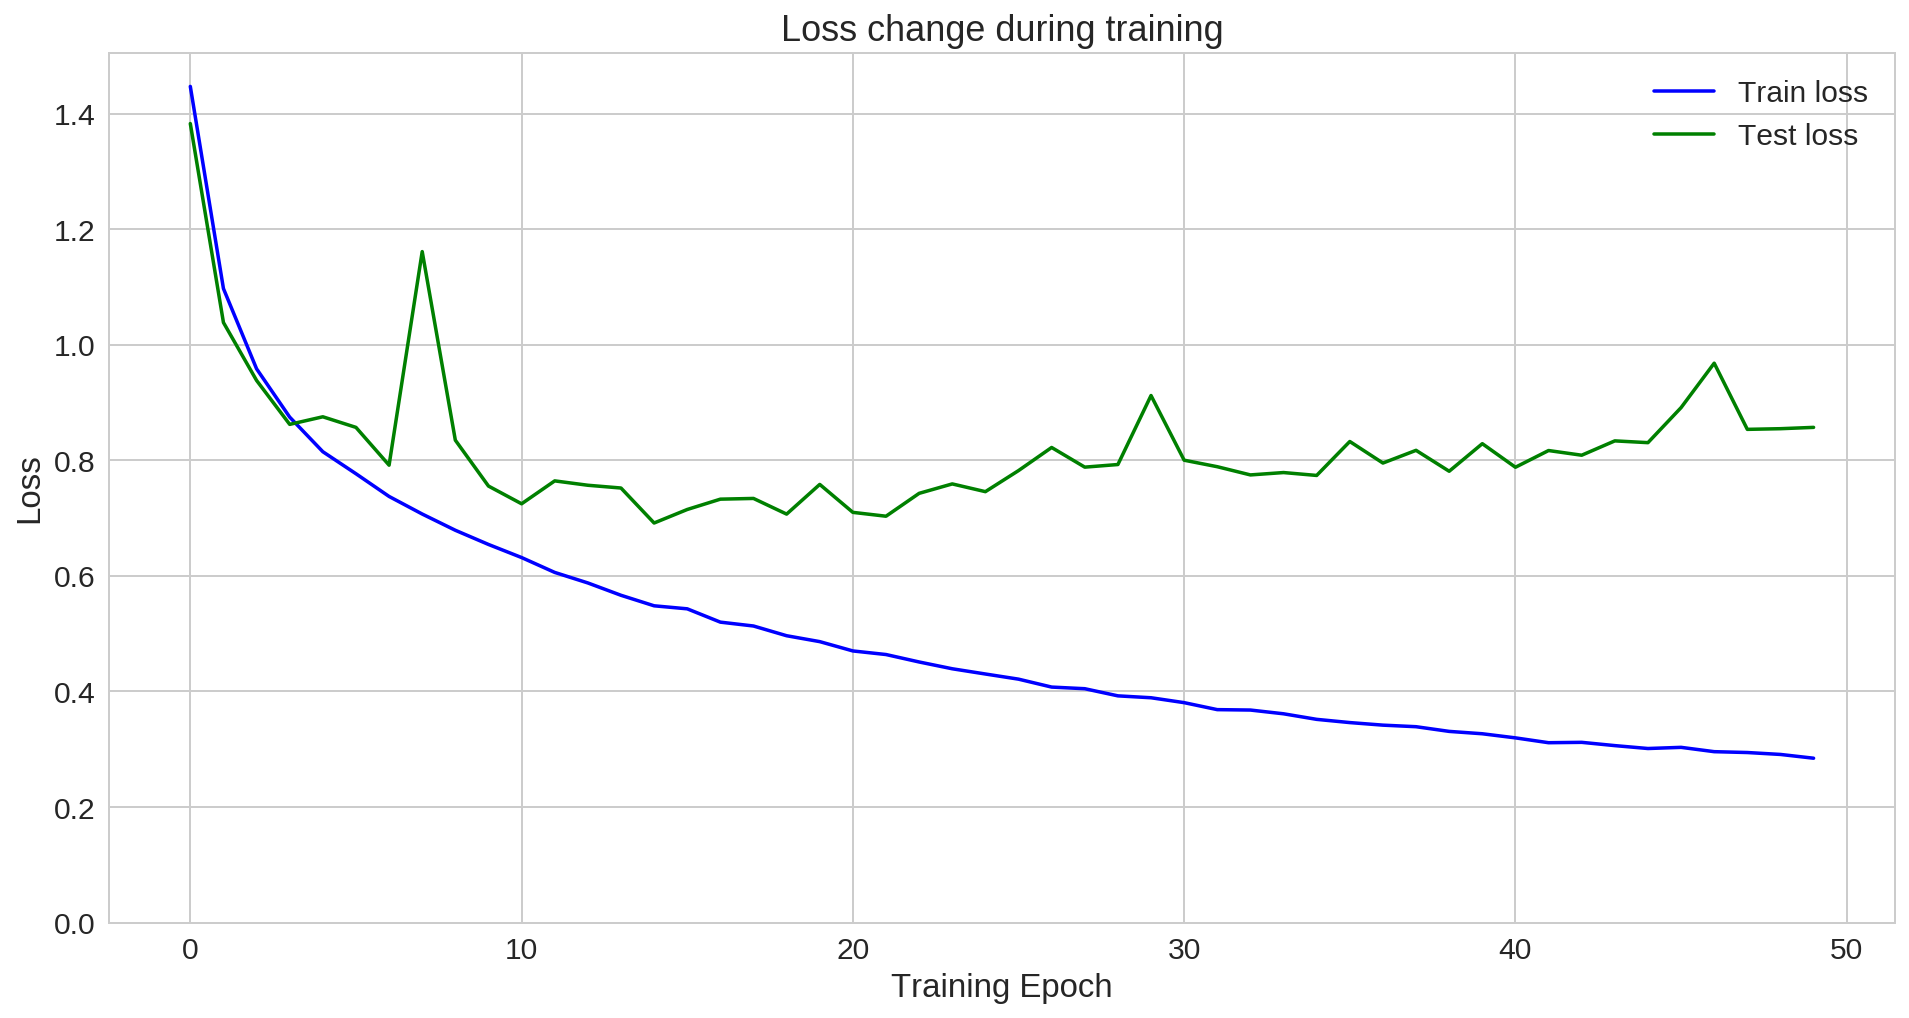

In [81]:
plt.figure(figsize=(16, 8))

plt.plot(train_loss, "b", label="Train loss")

plt.plot(test_loss, "g", label="Test loss")

plt.title("Loss change during training")
plt.legend(loc="upper right", shadow=True)
plt.ylabel("Loss")
plt.xlabel("Training Epoch")
plt.ylim(0)

plt.show()

In [0]:
model.eval()

ys = []
y_hats = []

for data, target in test_loader:
    data= Variable(data, volatile=True)
    
    if torch.cuda.is_available():
        data = data.cuda()
    
    output = model(data)

    pred = output.data.max(1, keepdim=True)[1]
    
    if torch.cuda.is_available():
        pred = pred.cpu()
    
    pred = pred.numpy().flatten()
    
    y_hats.extend(pred)
    ys.extend(target)

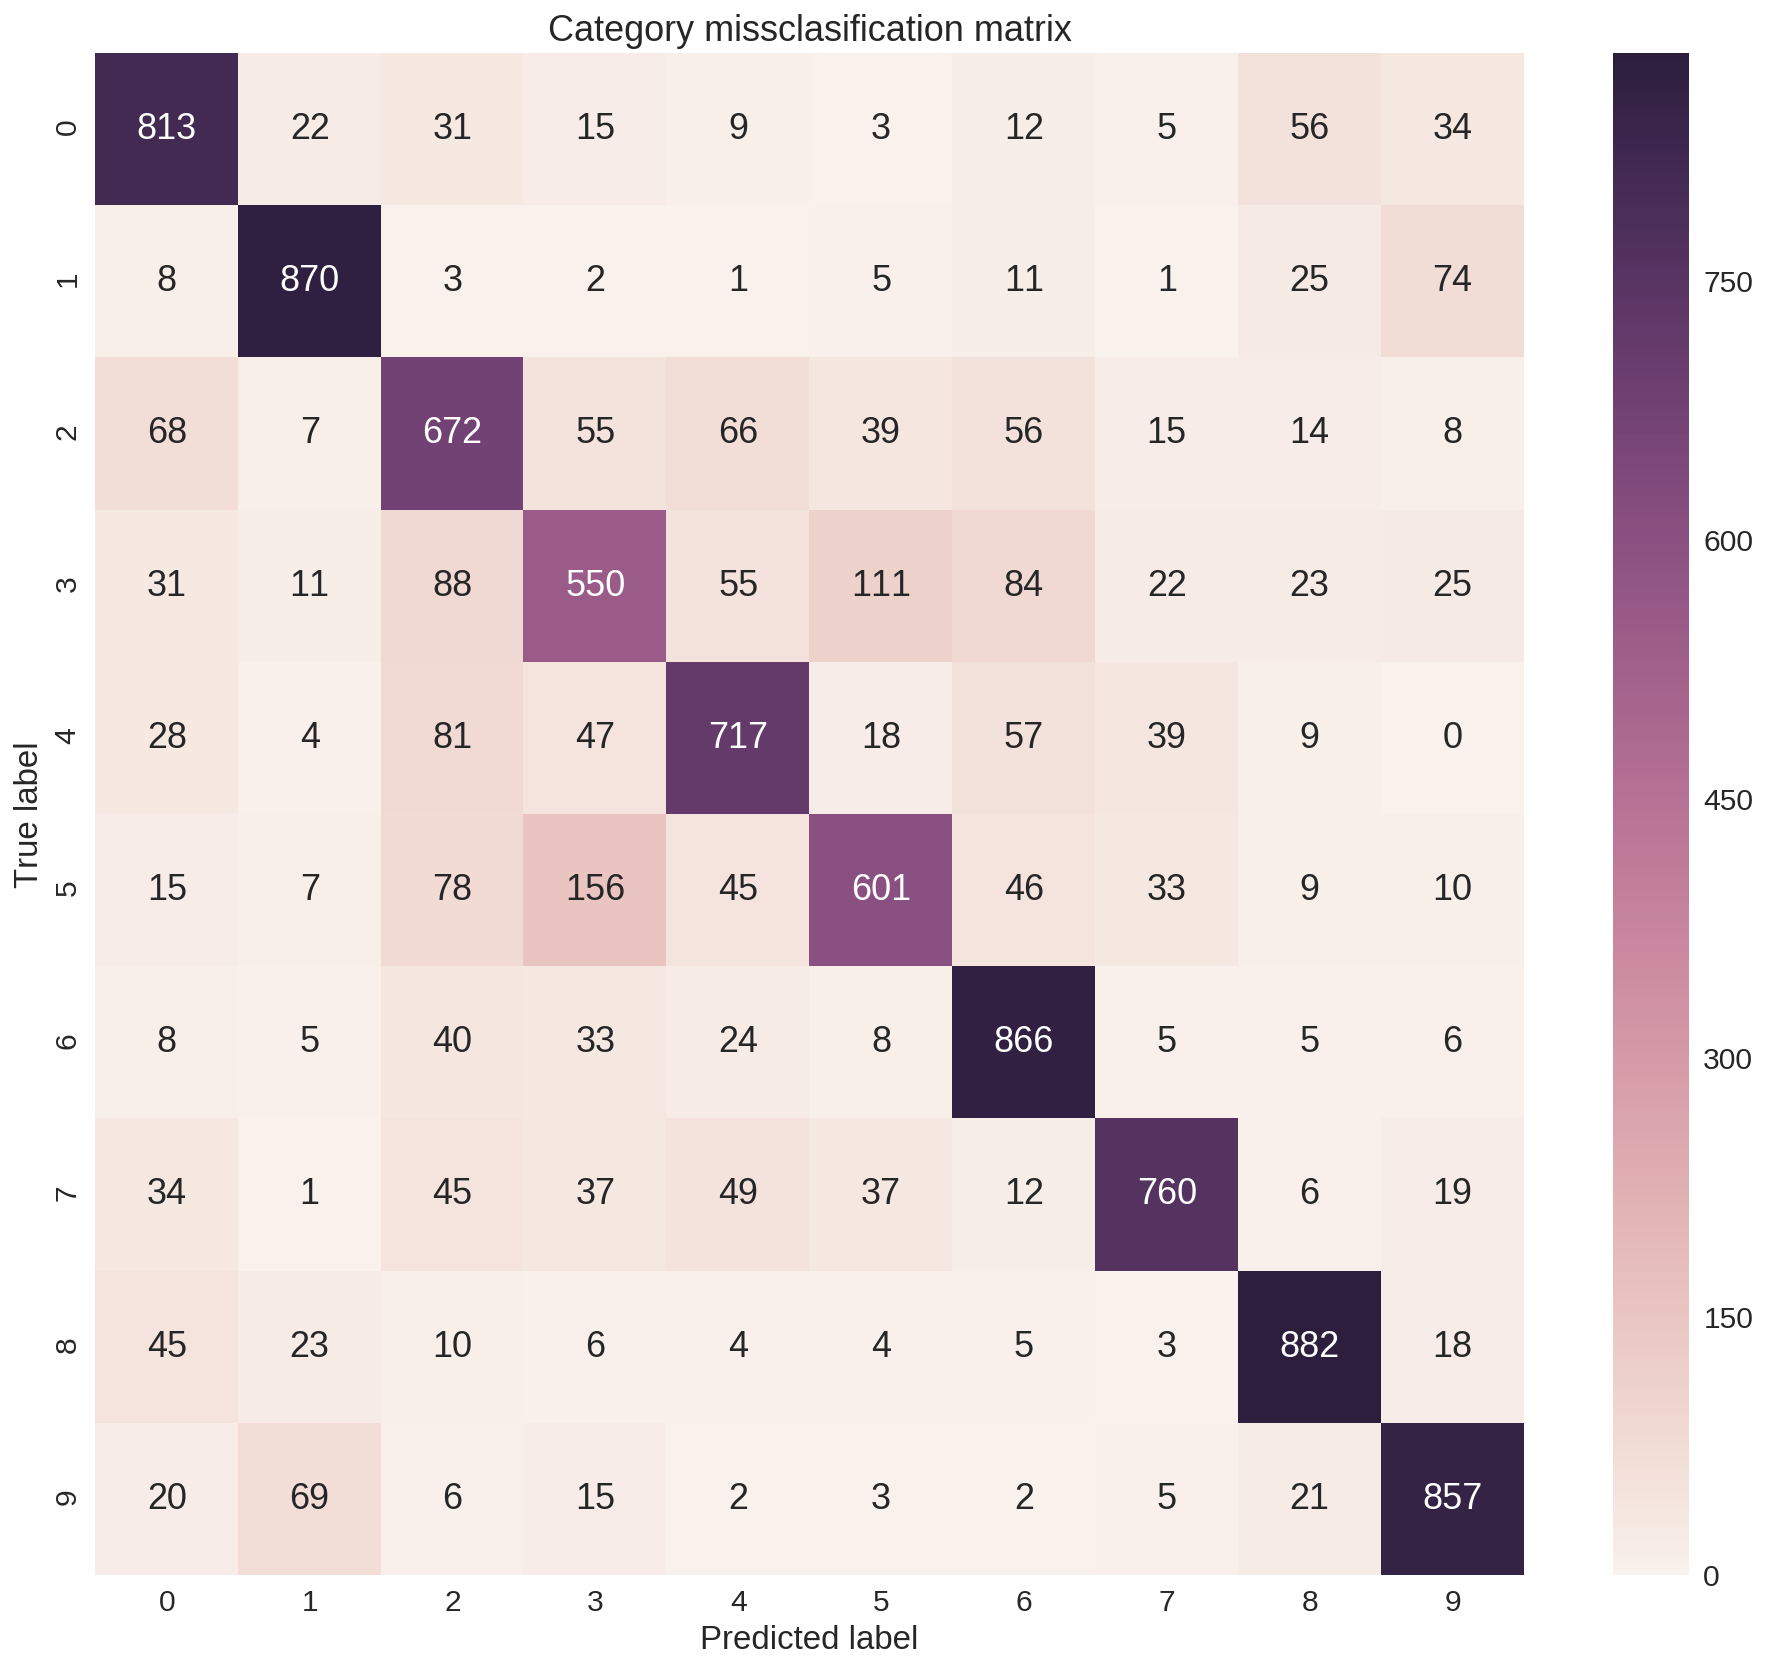

In [83]:
confusion_matrix = metrics.confusion_matrix(ys, y_hats)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Category missclasification matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()